## Testsite for more advanced ML schemes

**TODO**:
- Get better images man!
- Use contours or similar to only train on the shape of cup/boxes instead of on grayscales.

In [1]:
# Different useful libraries
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Helpers
from helpers import *
%run helpers.py

#### Get the augmented data

In [66]:
# Load images
cups, cup_size = import_images(path='henriks_images/augment_cup/')
boxes, box_size = import_images(path='henriks_images/augment_box/')

In [67]:
# Balance the data - we have more box data then cup data
#idx = np.random.randint(0, len(cups), len(cups))
#cups = np.asarray(cups)[idx, :, :, 0]
#boxes = np.asarray(boxes)[idx, :, :, 0]
cups = np.asarray(cups)[:, :, :, 0]
boxes = np.asarray(boxes)[:, :, :, 0]
cups.shape, boxes.shape

((594, 128, 128), (768, 128, 128))

### Basic data formatting
Splitting, normalization, pandas etc.

In [68]:
# Normalize advanced approach
(scaled_boxes, scaled_cups), scaler = normalize_2D(all_data=[boxes, cups], scaler_type='minmax')
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.0 0.9954128440366974 ) cups:( 0.10638297872340426 1.0000000000000002 )


In [69]:
# Normalize ez approach
scaled_boxes = boxes / 255
scaled_cups = cups / 255
print("boxes: (", scaled_boxes[0].min(), scaled_boxes[0].max(), ") cups:(", scaled_cups[0].min(), scaled_cups[0].max(), ")")


boxes: ( 0.06274509803921569 0.996078431372549 ) cups:( 0.13333333333333333 1.0 )


In [70]:
image_df = from_numpy_to_pd(data=[scaled_cups, scaled_boxes], labels=[0, 1])
train, test = train_test_split(image_df, test_size=0.2)

x_train = np.stack(train['data'], 0)
y_train = np.float32(train['label'])

x_test = np.stack(test['data'], 0)
y_test = np.float32(test['label'])

# For Keras this is required:
a, b, c = x_train.shape
x_train = x_train.reshape((a,b,c,1))
a, b, c = x_test.shape
x_test = x_test.reshape((a,b,c,1))


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1089, 128, 128, 1), (1089,), (273, 128, 128, 1), (273,))

### CNN - *conv. neural net time baby*!

***NB!*** Since we are for now only doing binary classification:
```
1. Change Categorical Cross Entropy to Binary Cross Entropy since your output label is binary.
2. Change Softmax to Sigmoid since Sigmoid is the proper activation function for binary data
```

Good sources:

- CONVNET on MINST: https://keras.io/examples/vision/mnist_convnet/
- Binary classification: https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible

In [71]:
input_shape = (128, 128, 1)

cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

batch_size = 124
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cnn_history = cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[early_stop, PrintDot()]
            )


..................................................

,loss,accuracy,val_loss,val_accuracy,epoch
49,0.092322,0.97551,0.169568,0.954128,49


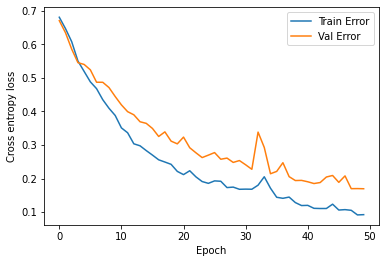

In [73]:
show_final_score(cnn_history)

**But this was easy! Using valiadtion data from the dataset itself**

In [11]:
score = cnn_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08092372119426727
Test accuracy: 0.9823232293128967


### Try out model on the real data!

In [12]:
from helpers import *
%run helpers.py

In [108]:
# Load raw images
real_cups, real_cup_size = import_images(path='test_samples/cups/')
real_boxes, real_box_size = import_images(path='test_samples/boxes/')
real_books, real_book_size = import_images(path='test_samples/books/')
# Reshape
real_cups = resize_and_flatten(real_cups, padding=False, max_size=real_cup_size, output_size=128, flatten=False)
real_boxes = resize_and_flatten(real_boxes, padding=False, max_size=real_box_size, output_size=128, flatten=False)
real_books = resize_and_flatten(real_books, padding=False, max_size=real_book_size, output_size=128, flatten=False)
# Scale
real_cups = real_cups / 255
real_boxes = real_boxes / 255
real_books = real_books / 255
# Shape for KERAS
a, b, c = real_cups.shape
real_cups = real_cups.reshape((a,b,c,1))
a, b, c = real_boxes.shape
real_boxes = real_boxes.reshape((a,b,c,1))
a, b, c = real_books.shape
real_books = real_books.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((len(real_cups),))
box_target = np.ones((len(real_boxes),))
book_target = np.ones((len(real_books),))*2

# Combine the data
test_data = np.concatenate((real_cups, real_boxes, real_books))
test_targets = np.concatenate((cup_target, box_target, book_target))

test_data.shape, test_targets.shape

((26, 128, 128, 1), (26,))

### Try training on the orginial data only

In [29]:
# Load images
cups, cup_size = import_images(path='henriks_images/Cups/')
boxes, box_size = import_images(path='henriks_images/Boxes/')

In [30]:
# Reshape
cups = resize_and_flatten(cups, padding=False, max_size=cup_size, output_size=128, flatten=False)
boxes = resize_and_flatten(boxes, padding=False, max_size=box_size, output_size=128, flatten=False)
# Scale
cups = cups / 255
boxes = boxes / 255
# Shape for KERAS
a, b, c = cups.shape
cups = cups.reshape((a,b,c,1))
a, b, c = boxes.shape
boxes = boxes.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((len(cups),))
box_target = np.ones((len(boxes),))

# Combine the data
x_train = np.concatenate((cups, boxes))
y_train = np.concatenate((cup_target, box_target))

x_train.shape, y_train.shape

((454, 128, 128, 1), (454,))

In [56]:
input_shape = (128, 128, 1)

simple_cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

simple_cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 124 #100
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

simple_cnn_history = simple_cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


.............................Epoch 00029: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
28,0.165535,0.963235,0.287378,0.869565,28


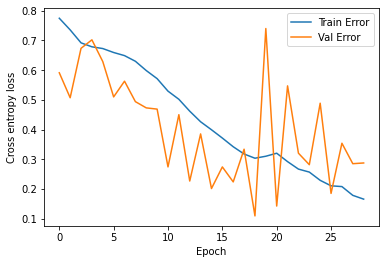

In [57]:
show_final_score(simple_cnn_history)

### Get all training data

In [76]:
## Load images
#cups, cup_size = import_images(path='henriks_images/Cups/')
#boxes, box_size = import_images(path='henriks_images/Boxes/')
#books, book_size = import_images(path='books/')
#len(cups), len(boxes), len(books)
#
## Reshape
#cups = resize_and_flatten(cups, padding=False, max_size=cup_size, output_size=128, flatten=False)
#boxes = resize_and_flatten(boxes, padding=False, max_size=box_size, output_size=128, flatten=False)
#books = resize_and_flatten(books, padding=False, max_size=book_size, output_size=128, flatten=False)

(198, 256, 218)

In [78]:
# Store the simple images
store_images(cups, path='henriks_images/small_cup/')
store_images(boxes, path='henriks_images/small_box/')
store_images(books, path='henriks_images/small_book/')


(198, 128, 128)
(256, 128, 128)
(218, 128, 128)


In [89]:
# Load images
cups, cup_size = import_images(path='henriks_images/small_cup/')
boxes, box_size = import_images(path='henriks_images/small_box/')
books, book_size = import_images(path='henriks_images/small_book/')
cups.shape, boxes.shape, books.shape

((198, 128, 128), (256, 128, 128), (218, 128, 128))

In [90]:
# Scale
cups = cups / 255
boxes = boxes / 255
books = books / 255
# Shape for KERAS
a, b, c = cups.shape
cups = cups.reshape((a,b,c,1))
a, b, c = boxes.shape
boxes = boxes.reshape((a,b,c,1))
a, b, c = books.shape
books = books.reshape((a,b,c,1))
# Targets cups, boxes = [0, 1]
cup_target = np.zeros((len(cups),))
box_target = np.ones((len(boxes),))
book_target = np.ones((len(books),))*2

# Combine the data
x_train = np.concatenate((cups, boxes, books))
y_train = np.concatenate((cup_target, box_target, book_target))

x_train.shape, y_train.shape

((672, 128, 128, 1), (672,))

In [97]:
y_train = y_train.astype(np.int32)
type(y_train[0]), y_train[-1]

(numpy.int32, 2)

In [99]:
input_shape = (128, 128, 1)

book_cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

book_cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 124 #100
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

book_cnn_history = book_cnn_model.fit(x_train, y_train,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


.........................Epoch 00025: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
24,0.085487,0.991722,0.374813,0.882353,24


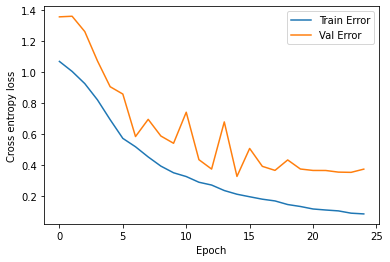

In [100]:
show_final_score(book_cnn_history)

In [110]:
score = book_cnn_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.0562533140182495
Test accuracy: 0.6153846383094788


### What if we chEaT?
- Adding the test samples to the training data, moHAHAHAH!

In [118]:
x_train_cheat = np.concatenate((x_train, test_data))
y_train_cheat = np.concatenate((y_train, test_targets))
x_train.shape, test_data.shape, x_train_cheat.shape, 

((672, 128, 128, 1), (26, 128, 128, 1), (698, 128, 128, 1))

In [119]:
input_shape = (128, 128, 1)

cheat_cnn_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"), #layers.Dense(2, activation="softmax"),
    ]
)

cheat_cnn_model.compile(
                loss=tf.keras.metrics.sparse_categorical_crossentropy, #loss="categorical_crossentropy", #loss=tf.keras.metrics.binary_crossentropy, 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"],
                )


batch_size = 124 #100
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=10) # 50

cheat_cnn_history = cheat_cnn_model.fit(x_train_cheat, y_train_cheat,
            batch_size=batch_size, epochs=epochs, 
            validation_split=0.1, verbose=0,
            callbacks=[PrintDot(), early_stop] # early_stop
            )


........................Epoch 00024: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
23,0.15458,0.96656,0.596686,0.771429,23


Test loss: 1.1045105457305908
Test accuracy: 0.5384615659713745


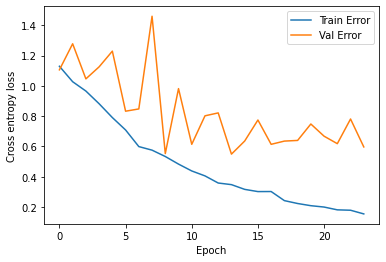

In [120]:
show_final_score(cheat_cnn_history)

cheat_score = cheat_cnn_model.evaluate(test_data, test_targets, verbose=0)
print("Test loss:", cheat_score[0])
print("Test accuracy:", cheat_score[1])

### Interesting, seems like cheating doesn't pay off